In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def load_df(mot_file: str) -> pd.DataFrame:
    df = pd.read_csv(
            mot_file,
            names=["frame", "id", "bb_left", "bb_top", "bb_width", "bb_height", "conf", "x", "y", "z"]
    )

    bottom_df = df[df["bb_top"] > 300].copy(deep=True)
    bottom_df["bb_top"] -= 300
    return bottom_df

mot_file = "ByteTrack/output/pNEUMA10_10-tiny.txt"

df = load_df(mot_file)

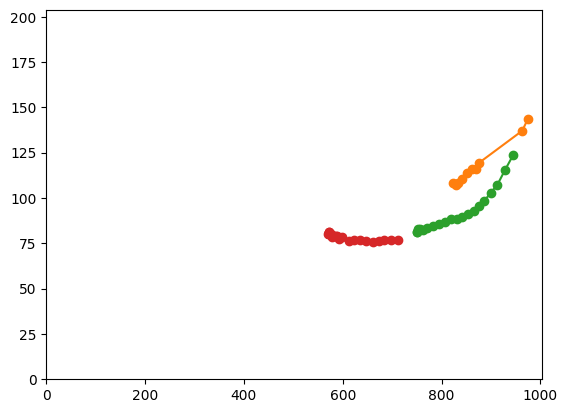

In [49]:
def get_center(df: pd.DataFrame) -> pd.DataFrame:
    """Gets the center of the car bounding box"""
    xs = df["bb_left"] + df["bb_width"] / 2
    ys = df["bb_top"] + df["bb_height"] / 2
    return pd.DataFrame({
        "frame": df["frame"],
        "x": xs,
        "y": ys,
        "id": df["id"],
        "conf": df["conf"],
    })

def get_trajectory(df: pd.DataFrame, veh_id: int) -> pd.DataFrame:
    """
    Gets the trajectory for the given vehicle id, that is, the center of 
    the car at each timestep that it's present.
    """
    traj = get_center(df[df["id"] == veh_id])
    return traj

def plot_trajectory(df: pd.DataFrame, veh_id: int | list[int]) -> pd.DataFrame:
    """Plots trajectories and returns it"""
    if type(veh_id) == int:
        traj = get_trajectory(df, veh_id)
        plt.plot(traj["x"], traj["y"], '-o')
    else:
        trajs = []
        for id in veh_id:
            traj = get_trajectory(df, id)
            plt.plot(traj["x"], traj["y"], '-o')
            trajs.append(traj)
        traj = trajs
    plt.xlim(0, df["bb_left"].max())
    plt.ylim(0, df["bb_top"].max())
    return traj

traj = plot_trajectory(df, list(range(5)))
_ = traj

,frame,x,y,id,conf
18,1,571.000269,79.999758,3,0.737287
48,2,571.867804,80.867736,3,0.638443
74,3,572.015614,81.015377,3,0.644556
102,4,572.045315,81.045021,3,0.653773
131,5,571.301610,80.301382,3,0.603356
155,6,571.769753,80.049844,3,0.537410
177,7,571.933922,79.967851,3,0.580162
206,8,573.358458,79.945393,3,0.746090
230,9,575.283887,79.947065,3,0.830556
268,10,578.701476,78.574402,3,0.685462


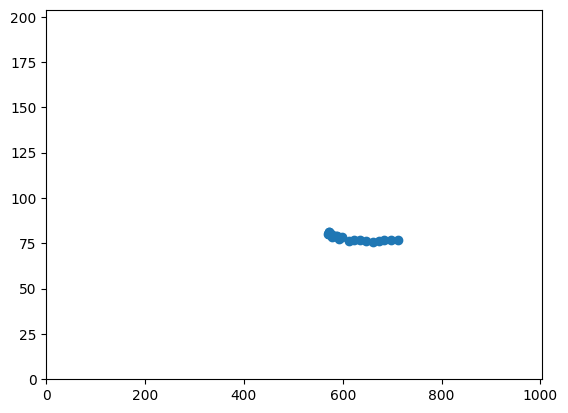

In [50]:
plot_trajectory(df, 3)

In [79]:
def near(traj: pd.DataFrame, df: pd.DataFrame):
    """ 
    Tries to calculate other trajectories which may be a continuation of 
    the fiven trajectory.
    """
    last_frame = traj["frame"].max()
    last_point = traj.iloc[[-1]]
    last_x = last_point["x"].values[0]
    last_y = last_point["y"].values[0]
    max_frames = 25
    fdf = df[
        (df["frame"] > last_frame) & (df["frame"] < last_frame + max_frames)
    ]
    res = fdf.loc[fdf.groupby("id")["frame"].idxmin()]
    print(type(res))
    res = res[((res["x"] - last_x)**2 + (res["y"] - last_y)**2) ** 0.5 < 100]
    return res

cdf = get_center(df)
# car 3 id switches to 106 and then to 185
traj = get_trajectory(df, 3)
p_ids = near(traj, cdf)

#_ = plot_trajectory(df, p_ids)
p_ids

<class 'pandas.core.frame.DataFrame'>


,frame,x,y,id,conf
711,26,691.301469,115.854566,17,0.810244
717,26,618.572120,110.409007,18,0.897376
714,26,673.152990,148.475258,21,0.907053
912,34,646.579819,79.044603,59,0.709645
696,26,724.222481,155.005506,69,0.442636
698,26,729.018662,75.036750,106,0.823372
1249,46,771.399772,103.000123,218,0.526860
1327,49,793.799823,109.799925,230,0.609096


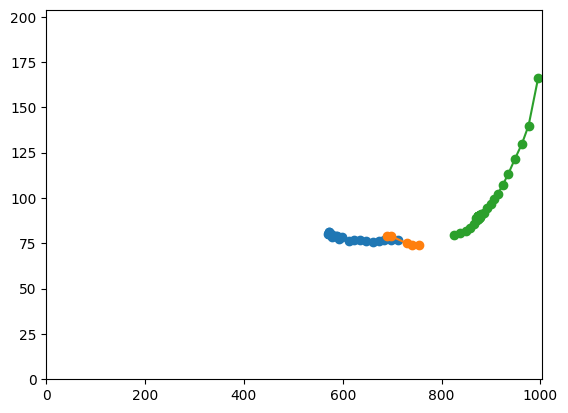

In [76]:
_ = plot_trajectory(df, [3, 106, 185])

<class 'pandas.core.frame.DataFrame'>


[     frame           x          y  id      conf
 18       1  571.000269  79.999758   3  0.737287
 48       2  571.867804  80.867736   3  0.638443
 74       3  572.015614  81.015377   3  0.644556
 102      4  572.045315  81.045021   3  0.653773
 131      5  571.301610  80.301382   3  0.603356
 155      6  571.769753  80.049844   3  0.537410
 177      7  571.933922  79.967851   3  0.580162
 206      8  573.358458  79.945393   3  0.746090
 230      9  575.283887  79.947065   3  0.830556
 268     10  578.701476  78.574402   3  0.685462
 294     11  583.252253  78.762560   3  0.541683
 319     12  586.210717  78.837473   3  0.637093
 347     13  589.302154  78.883660   3  0.453205
 380     14  592.404205  77.553760   3  0.269308
 414     15  598.022262  78.380194   3  0.446097
 449     17  612.373153  76.437368   3  0.649818
 475     18  623.227152  76.691791   3  0.614091
 500     19  635.770200  76.799430   3  0.445131
 524     20  647.491171  76.191995   3  0.764562
 553     21  660.303

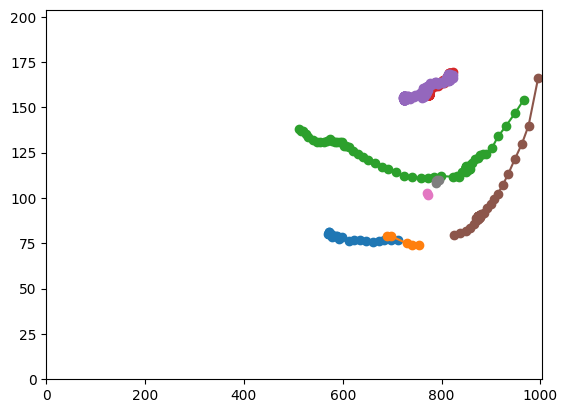

In [87]:
traj = get_trajectory(df, 106)
p_ids = near(traj, cdf)

#_ = plot_trajectory(df, p_ids)
plot_trajectory(df, [3, 106] + list(p_ids["id"].values))

In [85]:
df

,frame,id,bb_left,bb_top,bb_width,bb_height,conf,x,y,z
0,1,1,804.499558,97.000025,38.999962,22.000003,0.772708,-1,-1,-1
2,1,29,678.999552,71.500124,40.000000,21.000024,0.589487,-1,-1,-1
5,1,26,713.500262,92.500253,62.999962,27.000001,0.416747,-1,-1,-1
6,1,25,203.000013,176.499928,60.000051,32.999978,0.403087,-1,-1,-1
8,1,23,444.000051,70.000235,35.999949,17.999983,0.650595,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...
55859,1907,9374,537.516181,102.535783,37.491757,18.731707,0.742227,-1,-1,-1
55860,1907,9642,486.193681,108.131415,32.232816,16.931190,0.883681,-1,-1,-1
55863,1907,9641,363.509487,100.605112,35.141638,18.979490,0.890491,-1,-1,-1
55864,1907,9690,417.018938,106.465965,37.484636,19.148921,0.894639,-1,-1,-1
